## Dataset

In [1]:
buggy_data = ['((x + y) >= (z - 1))',
              '(a && b)',
              '(c > 0)',
              'd',
              '(e > f)']
fixed_data = ['((x + y) > (z - 1))',
              '(a && !(b))',
              '(c > 1)',
              '!(d)',
              '(f > e)']

In [2]:
buggy_codes = [list(x.replace(' ', '')) for x in buggy_data]
fixed_codes = [['<soc>']+list(x.replace(' ', ''))+['<eoc>'] for x in fixed_data]

In [3]:
print("Buggy codes:-")
for x in buggy_codes:
    print(x)
print("====================")
print("Fixed codes:-")
for x in fixed_codes:
    print(x)

Buggy codes:-
['(', '(', 'x', '+', 'y', ')', '>', '=', '(', 'z', '-', '1', ')', ')']
['(', 'a', '&', '&', 'b', ')']
['(', 'c', '>', '0', ')']
['d']
['(', 'e', '>', 'f', ')']
Fixed codes:-
['<soc>', '(', '(', 'x', '+', 'y', ')', '>', '(', 'z', '-', '1', ')', ')', '<eoc>']
['<soc>', '(', 'a', '&', '&', '!', '(', 'b', ')', ')', '<eoc>']
['<soc>', '(', 'c', '>', '1', ')', '<eoc>']
['<soc>', '!', '(', 'd', ')', '<eoc>']
['<soc>', '(', 'f', '>', 'e', ')', '<eoc>']


In [4]:
vocab = set([x for y in buggy_codes for x in y]+[x for y in fixed_codes for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [5]:
int_token_map

{1: '+',
 2: 'd',
 3: 'e',
 4: 'f',
 5: 'a',
 6: '<eoc>',
 7: 'y',
 8: '(',
 9: '>',
 10: '!',
 11: 'c',
 12: '&',
 13: '=',
 14: '1',
 15: 'x',
 16: '-',
 17: '0',
 18: 'b',
 19: 'z',
 20: '<soc>',
 21: ')',
 0: '<pad/unknown>'}

In [6]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in buggy_codes])
max_fixed_len = max([len(txt) for txt in fixed_codes])
num_dps = len(fixed_codes)

In [7]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 5
Vocabulary size: 22
Max length in buggy codes: 14
Max length in fixed codes: 15


In [8]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(buggy_codes, fixed_codes)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.

In [9]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W0921 21:57:38.245408 139731596580608 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0921 21:57:38.255612 139731596580608 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0921 21:57:38.259974 139731596580608 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0921 21:57:39.219430 139731596580608 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 15, 22)       18951190    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15)           0           model_2[1][0]                    
__________

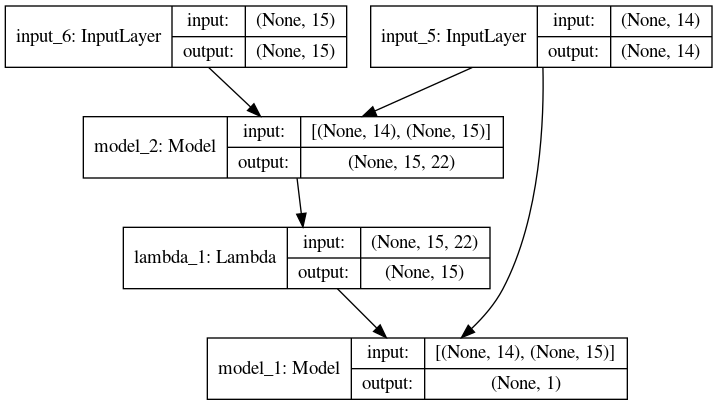

In [10]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_plot.png')

In [11]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<soc>"]
    for buggy, generated in zip(bugs, gntd_ints):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eoc>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints

In [12]:
import datetime


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in range(epochs):
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
end_time = datetime.datetime.now().replace(microsecond=0)

/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5/5 [==============================] - 3s 638ms/step - loss: 0.3449 - acc: 0.6000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 0.4081 - acc: 0.0000e+00


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5/5 [==============================] - 2s 412ms/step - loss: 309.5591 - model_1_loss: 0.6387 - model_2_loss: 3.0892
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2310 - acc: 1.0000


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5/5 [==============================] - 0s 9ms/step - loss: 0.5541 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 15ms/step - loss: 242.8841 - model_1_loss: 0.4287 - model_2_loss: 2.4246
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2019 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 0.4509 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 710.4489 - model_1_loss: 0.5081 - model_2_loss: 7.0994
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1946 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 0.3190 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 918.9831 - model_1_loss: 0.7838 - model_2_loss: 9.1820
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1782 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 0.

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 6.9587e-05 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 4.3654e-04 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 9.2071 - model_1_loss: 6.6295e-05 - model_2_loss: 0.0921
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 3.9651e-05 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 10ms/step - loss: 4.2185e-04 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 15ms/step - loss: 8.0544 - model_1_loss: 5.4612e-05 - model_2_loss: 0.0805


In [13]:
print("Training took (h:mm:ss)", end_time-start_time)

def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

Training took (h:mm:ss) 0:00:31


In [14]:
generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(buggy_codes, fixed_codes, generated_codes):
    print('Buggy code:', ' '.join(buggy))
    print('Fixed code:', ' '.join(fixed[1:-1]))
    print('Genration: ', ' '.join(gnrtd[1:]))
    print('=============')

Buggy code: ( ( x + y ) > = ( z - 1 ) )
Fixed code: ( ( x + y ) > ( z - 1 ) )
Genration:  ( ( x + y ) > ( z - 1 ) )
Buggy code: ( a & & b )
Fixed code: ( a & & ! ( b ) )
Genration:  ( a & & ! ( b ) )
Buggy code: ( c > 0 )
Fixed code: ( c > 1 )
Genration:  ( c > 1 )
Buggy code: d
Fixed code: ! ( d )
Genration:  ! ( d )
Buggy code: ( e > f )
Fixed code: ( f > e )
Genration:  ( f > e )
